# Define and predict when a tenant is good or bad from the point of view of a landlord

## 1. Load and Import Packages 

In [102]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import os
import math
import datetime
from datetime import datetime

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set up File Paths

In [2]:
import_bucket = "outputs/"

output_bucket = "outputs/"

## 3. Import Data 

In [3]:
pd.set_option('display.max_columns', None)
cons_and_trans = pd.read_csv(import_bucket + "clean_contracts_transactions_merge.csv")
cons_and_trans.head()

,name,surname,dob,avg_rent,total_contract_length,avg_contract_length,deposit_return_num,total_rent_gap,total_total_payments_gap,age_contract_start,num_contracts,late_payments_num,avg_late_perc,max_late,on_time_rent_num,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay,DIRECT_DEBIT,CASH,BANK_TRANSFER,num_pay_meth,postcode,all_pay_total,deposit_scale,contract_not_ended,total_rent_gap_norm,total_total_payments_gap_norm,late_payments_perc,late_payments_perc_norm,avg_late_perc_norm,max_late_norm,slowest_between_rent_pay_norm,bed_tenant_prob,bad_tenant
0,A Mateo,Chen,1961-05-08,3370.0,2040.0,2040.0,0.0,2.106250,1.0,52,1,3.0,0.050000,0.05,33,36,0.0,31.0,34.0,0.0,0.0,1.0,1,94107.0,36,0.0,1,0.000316,0.25,0.083333,0.088542,0.100000,0.1,0.369565,0.113553,0
1,A Shaad,Threlkeld,1989-08-24,2250.0,1950.0,1950.0,0.0,35.156250,1.0,24,1,13.0,0.057692,0.10,23,36,0.0,30.0,40.0,1.0,0.0,0.0,1,92808.0,36,0.0,1,0.005279,0.25,0.361111,0.383681,0.115385,0.2,0.434783,0.173641,0
2,A'Aniylah,Bautista,1972-12-27,1770.0,1003.0,1003.0,3.0,0.000000,0.0,43,1,23.0,0.117391,0.50,7,32,0.0,29.0,63.0,0.0,0.0,1.0,1,91790.0,34,1.0,0,0.000000,0.00,0.718750,0.763672,0.234783,1.0,0.684783,0.585405,1
3,A'Dore,Hager,1950-03-27,2140.0,251.0,251.0,0.0,0.000000,0.0,68,1,2.0,0.050000,0.05,7,9,0.0,31.0,38.0,1.0,0.0,0.0,1,93940.0,10,0.0,1,0.000000,0.00,0.222222,0.236111,0.100000,0.1,0.413043,0.106144,0
4,A'Dore,Hager,1964-03-18,2150.0,1614.0,1614.0,0.0,29.263889,1.0,50,1,9.0,0.077778,0.20,27,36,0.0,30.5,43.0,1.0,0.0,0.0,1,91355.0,36,0.0,1,0.004394,0.25,0.250000,0.265625,0.155556,0.4,0.467391,0.192871,0


In [139]:
cons_and_trans['deposit_return_num'].value_counts()

0.0    9176
2.0    1988
3.0     188
1.0     117
Name: deposit_return_num, dtype: int64

Count classes

In [4]:
cons_and_trans['bad_tenant'].value_counts()

0    10266
1     1203
Name: bad_tenant, dtype: int64

In [92]:
1203/(10266+1203)

0.10489144650797803

## 4. Prepare Data for Modeling

In [93]:
cons_and_trans_x = cons_and_trans[['total_contract_length','age_contract_start','num_contracts','num_pay_meth','contract_not_ended', 'DIRECT_DEBIT', 'CASH','BANK_TRANSFER']]

cons_and_trans_y = cons_and_trans[['bad_tenant']]

Check missingness

In [94]:
cons_and_trans.isnull().sum()

name                             0
surname                          0
dob                              0
avg_rent                         0
total_contract_length            0
avg_contract_length              0
deposit_return_num               0
total_rent_gap                   0
total_total_payments_gap         0
age_contract_start               0
num_contracts                    0
late_payments_num                0
avg_late_perc                    0
max_late                         0
on_time_rent_num                 0
num_rent_pay                     0
fastest_between_rent_pay         0
median_between_rent_pay          0
slowest_between_rent_pay         0
DIRECT_DEBIT                     0
CASH                             0
BANK_TRANSFER                    0
num_pay_meth                     0
postcode                         0
all_pay_total                    0
deposit_scale                    0
contract_not_ended               0
total_rent_gap_norm              0
total_total_payments

## 5. Modeling

In [7]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(cons_and_trans_x, cons_and_trans_y, test_size=0.2, random_state=42)

1. Basic Logression - Baseline

In [8]:
logreg = LogisticRegression(penalty='l1').fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train.values.ravel())))
print("Test score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.904
Test score: 0.905


C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Check results of L1 Regularization

In [9]:
logreg.coef_[logreg.coef_!=0].shape

(8,)

In [10]:
y_pred = logreg.predict(X_test)

In [11]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.68      0.21      0.32       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.80      0.60      0.63      2294
weighted avg       0.89      0.90      0.88      2294



In [12]:
roc_auc_score(y_test,y_pred)

0.5982251172797084

2. Decision Tree - Baseline

In [13]:
tree = DecisionTreeClassifier(max_depth = 5, random_state=0)
tree.fit(X_train, y_train)
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("Test score: {:.3f}".format(tree.score(X_test, y_test)))

Training set score: 0.908
Test score: 0.905


In [14]:
y_pred = tree.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.68      0.21      0.32       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.80      0.60      0.63      2294
weighted avg       0.89      0.90      0.88      2294



In [15]:
roc_auc_score(y_test,y_pred)

0.5982251172797084

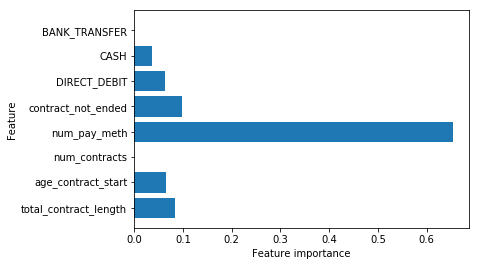

In [16]:
def plot_feature_importances(model):
    n_features = cons_and_trans_x.values.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cons_and_trans_x.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(tree)

3. Random Forest

In [17]:
forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest.fit(X_train, y_train)
print("Training set score: {:.3f}".format(forest.score(X_train, y_train)))
print("Test score: {:.3f}".format(forest.score(X_test, y_test)))

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training set score: 0.995
Test score: 0.879


In [18]:
y_pred = forest.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2049
           1       0.40      0.26      0.31       245

   micro avg       0.88      0.88      0.88      2294
   macro avg       0.66      0.61      0.62      2294
weighted avg       0.86      0.88      0.87      2294



In [19]:
roc_auc_score(y_test,y_pred)

0.6051453670780171

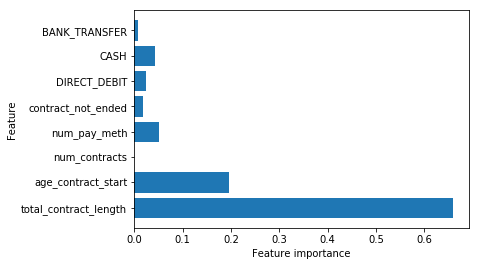

In [20]:
plot_feature_importances(forest)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 109, 118, 127, 136, 145, 154, 163, 172, 181, 190, 200, 209, 218, 227, 236, 245, 254, 263, 272, 281, 290, 300, 309, 318, 327, 336, 345, 354, 363, 372, 381, 390, 400, 409, 418, 427, 436, 445, 454, 463, 472, 481, 490, 500, 509, 518, 527, 536, 545, 554, 563, 572, 581, 590, 600, 609, 618, 627, 636, 645, 654, 663, 672, 681, 690, 700, 709, 718, 727, 736, 745, 754, 763, 772, 781, 790, 800, 809, 818, 827, 836, 845, 854, 863, 872, 881, 890, 900, 909, 918, 927, 936, 945, 954, 963, 972, 981, 990, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print("Training set score: {:.3f}".format(rf_random.score(X_train, y_train)))
print("Test score: {:.3f}".format(rf_random.score(X_test, y_test)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.6min finished
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training set score: 0.910
Test score: 0.908


In [23]:
rf_random.best_params_

{'n_estimators': 645,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [24]:
y_pred = rf_random.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.74      0.21      0.32       245

   micro avg       0.91      0.91      0.91      2294
   macro avg       0.83      0.60      0.64      2294
weighted avg       0.89      0.91      0.88      2294



In [25]:
roc_auc_score(y_test,y_pred)

0.5996892461230467

4. Gradient Boosted Reg Tree

In [26]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, n_estimators = 100)
gbrt.fit(X_train, y_train)
print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set score: 0.905
Test score: 0.904


In [27]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.72      0.17      0.27       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.81      0.58      0.61      2294
weighted avg       0.89      0.90      0.88      2294



In [28]:
roc_auc_score(y_test,y_pred)

0.5797691258055199

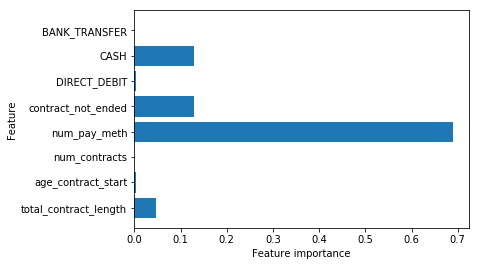

In [29]:
plot_feature_importances(gbrt)

4.5. Gradient Boosting with Early Stopping

In [30]:
errors = [roc_auc_score(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators = bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.905
Test score: 0.904


C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.72      0.17      0.27       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.81      0.58      0.61      2294
weighted avg       0.89      0.90      0.88      2294



In [32]:
roc_auc_score(y_test,y_pred)

0.5797691258055199

4.75. Gradient Boosting Warm Start Method

In [33]:
gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train.values.ravel())
    y_pred = gbrt.predict(X_test)
    val_error = roc_auc_score(y_test,y_pred) 
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else: 
        error_going_up += 1
        if error_going_up == 5:
            break

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators = gbrt.n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train.values.ravel())

print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.896
Test score: 0.893


In [34]:
print(gbrt.n_estimators)

6


In [35]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2049
           1       0.00      0.00      0.00       245

   micro avg       0.89      0.89      0.89      2294
   macro avg       0.45      0.50      0.47      2294
weighted avg       0.80      0.89      0.84      2294



C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
roc_auc_score(y_test,y_pred)

0.5

5. SVM

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [38]:
svm = SVC(kernel='rbf', gamma="scale")
svm.fit(X_train_scaled, y_train.values.ravel())
print("Training set score: {:.3f}".format(svm.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(svm.score(X_test_scaled, y_test)))

Training set score: 0.904
Test score: 0.905


In [39]:
y_pred = svm.predict(X_test_scaled)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.68      0.21      0.32       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.80      0.60      0.63      2294
weighted avg       0.89      0.90      0.88      2294



In [40]:
roc_auc_score(y_test,y_pred)

0.5982251172797084

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [42]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C":uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=6.079561932872973, gamma=0.09600933311034096 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=6.079561932872973, gamma=0.09600933311034096, total=   1.0s
[CV] C=6.079561932872973, gamma=0.09600933311034096 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ... C=6.079561932872973, gamma=0.09600933311034096, total=   1.1s
[CV] C=6.079561932872973, gamma=0.09600933311034096 ..................
[CV] ... C=6.079561932872973, gamma=0.09600933311034096, total=   1.1s
[CV] C=6.3015103984211756, gamma=0.0017624472049762795 ...............
[CV]  C=6.3015103984211756, gamma=0.0017624472049762795, total=   0.3s
[CV] C=6.3015103984211756, gamma=0.0017624472049762795 ...............
[CV]  C=6.3015103984211756, gamma=0.0017624472049762795, total=   0.2s
[CV] C=6.3015103984211756, gamma=0.0017624472049762795 ...............
[CV]  C=6.3015103984211756, gamma=0.0017624472049762795, total=   0.3s
[CV] C=3.497728018995481, gamma=0.05016374399047416 ..................
[CV] ... C=3.497728018995481, gamma=0.05016374399047416, total=   0.7s
[CV] C=3.497728018995481, gamma=0.05016374399047416 ..................
[CV] ... C=3.497728018995481, gamma=0.05016374399047416, total=   0.7s
[CV] C=3.497728018995481, gamma=0.05016374399047416 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C6FB7C3320>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C6FB96DAC8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [43]:
rnd_search_cv.best_estimator_

SVC(C=6.3015103984211756, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0017624472049762795,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [44]:
rnd_search_cv.best_score_

0.9043051771117167

In [45]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train.values.ravel())

SVC(C=6.3015103984211756, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0017624472049762795,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [46]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2049
           1       0.68      0.21      0.32       245

   micro avg       0.90      0.90      0.90      2294
   macro avg       0.80      0.60      0.63      2294
weighted avg       0.89      0.90      0.88      2294



In [47]:
roc_auc_score(y_test,y_pred)

0.5982251172797084

## 6. Dealing with Class Imbalance

### Upsampling

In [48]:
y_train['bad_tenant'].value_counts()

0    8217
1     958
Name: bad_tenant, dtype: int64

In [105]:
from sklearn.preprocessing import LabelEncoder

X = cons_and_trans_x.values
y = cons_and_trans_y.values

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

X_imb = np.vstack((X[y == 0], X[y == 1]))
y_imb = np.hstack((y[y == 0], y[y == 1]))

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
from sklearn.utils import resample

print("Number of class 1 examples before:", X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)

print("Number of class 1 examples after:", X_upsampled.shape[0])

Number of class 1 examples before: 1203
Number of class 1 examples after: 10266


In [107]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [109]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=0)

1. Logistic Reg

In [110]:
logreg = LogisticRegression(penalty='l1').fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.655
Test score: 0.654


C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [111]:
y_pred = logreg.predict(X_test)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      2050
           1       0.70      0.54      0.61      2057

   micro avg       0.65      0.65      0.65      4107
   macro avg       0.66      0.65      0.65      4107
weighted avg       0.66      0.65      0.65      4107



In [112]:
roc_auc_score(y_test,y_pred)

0.6537062024971246

Decision Tree

In [113]:
tree = DecisionTreeClassifier(max_depth = 5, random_state=0)
tree.fit(X_train, y_train)
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("Test score: {:.3f}".format(tree.score(X_test, y_test)))

Training set score: 0.659
Test score: 0.658


In [114]:
y_pred = tree.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2050
           1       0.71      0.53      0.61      2057

   micro avg       0.66      0.66      0.66      4107
   macro avg       0.67      0.66      0.65      4107
weighted avg       0.67      0.66      0.65      4107



In [115]:
roc_auc_score(y_test,y_pred)

0.6581130464683355

Random Forest

In [116]:
forest_upsamp = RandomForestClassifier(n_estimators=500, random_state=42)
forest_upsamp.fit(X_train, y_train)
print("Training set score: {:.3f}".format(forest_upsamp.score(X_train, y_train)))
print("Test score: {:.3f}".format(forest_upsamp.score(X_test, y_test)))

Training set score: 0.996
Test score: 0.941


In [117]:
y_pred = forest_upsamp.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      2050
           1       0.90      1.00      0.94      2057

   micro avg       0.94      0.94      0.94      4107
   macro avg       0.95      0.94      0.94      4107
weighted avg       0.95      0.94      0.94      4107



In [118]:
roc_auc_score(y_test,y_pred)

0.9409764397595363

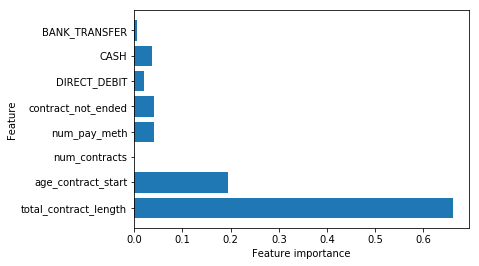

In [119]:
plot_feature_importances(forest_upsamp)

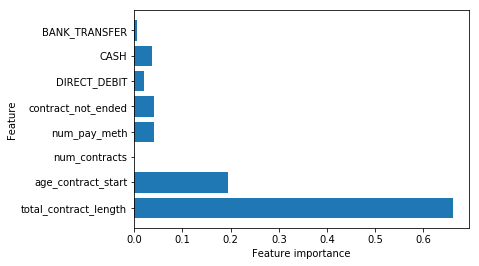

In [121]:
def plot_feature_importances_save(model):
    n_features = cons_and_trans_x.values.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cons_and_trans_x.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.savefig(output_bucket + 'forest_upsamp.png', bbox_inches='tight')
plot_feature_importances_save(forest_upsamp)    

In [122]:
# Check on likely directionality
cons_and_trans[cons_and_trans['bad_tenant'] == 1]['total_contract_length'].describe()

count    1203.000000
mean      997.566916
std       586.692225
min        27.000000
25%       487.000000
50%       933.000000
75%      1483.000000
max      2187.000000
Name: total_contract_length, dtype: float64

In [123]:
cons_and_trans[cons_and_trans['bad_tenant'] == 0]['total_contract_length'].describe()

count    10266.000000
mean       914.547536
std        621.455948
min          0.000000
25%        377.000000
50%        819.000000
75%       1417.000000
max       2191.000000
Name: total_contract_length, dtype: float64

In [124]:
# Check on likely directionality
cons_and_trans[cons_and_trans['bad_tenant'] == 1]['age_contract_start'].describe()

count    1203.000000
mean       43.397340
std        13.084967
min        19.000000
25%        32.000000
50%        43.000000
75%        55.000000
max        68.000000
Name: age_contract_start, dtype: float64

In [125]:
cons_and_trans[cons_and_trans['bad_tenant'] == 0]['age_contract_start'].describe()

count    10266.000000
mean        44.164718
std         12.918963
min         19.000000
25%         33.000000
50%         44.000000
75%         55.000000
max         68.000000
Name: age_contract_start, dtype: float64

In [126]:
# Check on likely directionality
cons_and_trans[cons_and_trans['bad_tenant'] == 1]['CASH'].describe()

count    1203.000000
mean        0.086879
std         0.269489
min         0.000000
25%         0.000000
50%         0.000000
75%         0.025641
max         1.000000
Name: CASH, dtype: float64

In [127]:
cons_and_trans[cons_and_trans['bad_tenant'] == 0]['CASH'].describe()

count    10266.000000
mean         0.045496
std          0.207486
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: CASH, dtype: float64

In [128]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, n_estimators = 100)
gbrt.fit(X_train, y_train)
print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.661
Test score: 0.662


In [129]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2050
           1       0.71      0.55      0.62      2057

   micro avg       0.66      0.66      0.66      4107
   macro avg       0.67      0.66      0.66      4107
weighted avg       0.67      0.66      0.66      4107



In [130]:
roc_auc_score(y_test,y_pred)

0.6619905853895681

In [131]:
errors = [roc_auc_score(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators = bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.661
Test score: 0.662


In [132]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2050
           1       0.71      0.55      0.62      2057

   micro avg       0.66      0.66      0.66      4107
   macro avg       0.67      0.66      0.66      4107
weighted avg       0.67      0.66      0.66      4107



In [133]:
roc_auc_score(y_test,y_pred)

0.6619905853895681

SVM

In [134]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svm = SVC(kernel='rbf', gamma="scale")
svm.fit(X_train_scaled, y_train)
print("Training set score: {:.3f}".format(svm.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(svm.score(X_test_scaled, y_test)))

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C":uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

Training set score: 0.656
Test score: 0.652
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.719620934998668, gamma=0.012025576617425395 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=5.719620934998668, gamma=0.012025576617425395, total=   7.5s
[CV] C=5.719620934998668, gamma=0.012025576617425395 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] .. C=5.719620934998668, gamma=0.012025576617425395, total=   6.5s
[CV] C=5.719620934998668, gamma=0.012025576617425395 .................
[CV] .. C=5.719620934998668, gamma=0.012025576617425395, total=   6.2s
[CV] C=1.9662176122979127, gamma=0.051721418082996636 ................
[CV] . C=1.9662176122979127, gamma=0.051721418082996636, total=   6.6s
[CV] C=1.9662176122979127, gamma=0.051721418082996636 ................
[CV] . C=1.9662176122979127, gamma=0.051721418082996636, total=   7.4s
[CV] C=1.9662176122979127, gamma=0.051721418082996636 ................
[CV] . C=1.9662176122979127, gamma=0.051721418082996636, total=   7.9s
[CV] C=10.344069060852974, gamma=0.015588386283194392 ................
[CV] . C=10.344069060852974, gamma=0.015588386283194392, total=  10.8s
[CV] C=10.344069060852974, gamma=0.015588386283194392 ................
[CV] . C=10.344069060852974, gamma=0.015588386283194392, total=   9.6s
[CV] C=10.344069060852974, gamma=0.015588386283194392 ................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.7min finished


SVC(C=7.750587811580133, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.04336971323445205,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [135]:
print("Training set score: {:.3f}".format(rnd_search_cv.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(rnd_search_cv.score(X_test_scaled, y_test)))

Training set score: 0.656
Test score: 0.654


In [136]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      2050
           1       0.70      0.54      0.61      2057

   micro avg       0.65      0.65      0.65      4107
   macro avg       0.66      0.65      0.65      4107
weighted avg       0.66      0.65      0.65      4107



In [137]:
roc_auc_score(y_test,y_pred)

0.6541981573923664

Downsampling

In [138]:
print("Number of class 1 examples before:", X_imb[y_imb == 0].shape[0])

X_downsampled, y_downsampled = resample(X_imb[y_imb == 0], y_imb[y_imb == 0], replace=True, n_samples=X_imb[y_imb == 1].shape[0], random_state=123)

print("Number of class 1 examples after:", X_downsampled.shape[0])


X_bal = np.vstack((X[y == 1], X_downsampled))
y_bal = np.hstack((y[y == 1], y_downsampled))

Number of class 1 examples before: 10266
Number of class 1 examples after: 1203


In [140]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=0)

Logistic Regression

In [141]:
logreg = LogisticRegression(penalty='l1').fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.656
Test score: 0.672


C:\Users\Christian Conroy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [142]:
y_pred = logreg.predict(X_test)

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       235
           1       0.74      0.56      0.64       247

   micro avg       0.67      0.67      0.67       482
   macro avg       0.68      0.67      0.67       482
weighted avg       0.68      0.67      0.67       482



In [143]:
roc_auc_score(y_test,y_pred)

0.6749935394952192

Decision Tree

In [144]:
tree = DecisionTreeClassifier(max_depth = 5, random_state=0)
tree.fit(X_train, y_train)
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("Test score: {:.3f}".format(tree.score(X_test, y_test)))

Training set score: 0.672
Test score: 0.654


In [145]:
y_pred = tree.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       235
           1       0.72      0.52      0.61       247

   micro avg       0.65      0.65      0.65       482
   macro avg       0.67      0.66      0.65       482
weighted avg       0.67      0.65      0.65       482



In [146]:
roc_auc_score(y_test,y_pred)

0.6568782840899303

Random Forest

In [147]:
forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest.fit(X_train, y_train)
print("Training set score: {:.3f}".format(forest.score(X_train, y_train)))
print("Test score: {:.3f}".format(forest.score(X_test, y_test)))

Training set score: 0.997
Test score: 0.616


In [148]:
y_pred = forest.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       235
           1       0.63      0.62      0.62       247

   micro avg       0.62      0.62      0.62       482
   macro avg       0.62      0.62      0.62       482
weighted avg       0.62      0.62      0.62       482



In [149]:
roc_auc_score(y_test,y_pred)

0.6160995779136876

Gradient Boosting

In [150]:
errors = [roc_auc_score(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators = bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

print("Training set score: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Test score: {:.3f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.663
Test score: 0.674


In [151]:
y_pred = gbrt.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       235
           1       0.73      0.57      0.64       247

   micro avg       0.67      0.67      0.67       482
   macro avg       0.68      0.68      0.67       482
weighted avg       0.69      0.67      0.67       482



In [152]:
roc_auc_score(y_test,y_pred)

0.6769144629167025

SVC

In [153]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svm = SVC(kernel='rbf', gamma="scale")
svm.fit(X_train_scaled, y_train)
print("Training set score: {:.3f}".format(svm.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(svm.score(X_test_scaled, y_test)))

Training set score: 0.664
Test score: 0.656


In [154]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C":uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.82600340568459, gamma=0.019350964794581017 ..................
[CV] ... C=5.82600340568459, gamma=0.019350964794581017, total=   0.0s
[CV] C=5.82600340568459, gamma=0.019350964794581017 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=5.82600340568459, gamma=0.019350964794581017, total=   0.0s
[CV] C=5.82600340568459, gamma=0.019350964794581017 ..................
[CV] ... C=5.82600340568459, gamma=0.019350964794581017, total=   0.0s
[CV] C=3.821086133733793, gamma=0.011404562020369671 .................
[CV] .. C=3.821086133733793, gamma=0.011404562020369671, total=   0.0s
[CV] C=3.821086133733793, gamma=0.011404562020369671 .................
[CV] .. C=3.821086133733793, gamma=0.011404562020369671, total=   0.0s
[CV] C=3.821086133733793, gamma=0.011404562020369671 .................
[CV] .. C=3.821086133733793, gamma=0.011404562020369671, total=   0.0s
[CV] C=10.513787652040095, gamma=0.016180570904378393 ................
[CV] . C=10.513787652040095, gamma=0.016180570904378393, total=   0.0s
[CV] C=10.513787652040095, gamma=0.016180570904378393 ................
[CV] . C=10.513787652040095, gamma=0.016180570904378393, total=   0.0s
[CV] C=10.513787652040095, gamma=0.016180570904378393 ................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.4s finished


SVC(C=2.612183793450528, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.006536283054972046,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [155]:
print("Training set score: {:.3f}".format(rnd_search_cv.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(rnd_search_cv.score(X_test_scaled, y_test)))

Training set score: 0.653
Test score: 0.666


In [156]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.82      0.70       235
           1       0.75      0.52      0.62       247

   micro avg       0.67      0.67      0.67       482
   macro avg       0.68      0.67      0.66       482
weighted avg       0.69      0.67      0.66       482



In [157]:
roc_auc_score(y_test,y_pred)

0.6696442415367388

Save Best Model

In [103]:
filename = 'finalized_model.sav'
pickle.dump(forest_upsamp, open(filename, 'wb'))